# Emotion Detection From Text
This project builds an Emotion Classification Model using RoBERTa, fine-tuned on a curated dataset of social-media text. The goal is to automatically predict the underlying emotion expressed in text messages.

## Imports

In [1]:
# Basic utilities
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# NLP feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
!pip install transformers datasets accelerate -q

## Loading Dataset
Here, we load the dataset and see what labels exist.

In [4]:
df = pd.read_excel('/content/emotion_dataset_raw.xlsx')

df.value_counts('Emotion')

,count
Emotion,
joy,11045
sadness,6722
fear,5410
anger,4297
surprise,4062
neutral,3680
disgust,856
shame,146


## Preprocessing Dataset
First, we remove labels with few entries like *shame* and *disgust*.
</br>Also, we randomly half the number of entries in *joy* to balance the dataset.

In [5]:
df = df[df['Emotion'] != 'shame']
df = df[df['Emotion'] != 'disgust']

joy_df = df[df['Emotion'] == 'joy'].sample(frac=0.5, random_state=42)  # take 50% randomly
others_df = df[df['Emotion'] != 'joy']

df = pd.concat([joy_df, others_df]).reset_index(drop=True)

New values:

In [6]:
df.value_counts('Emotion')

,count
Emotion,
sadness,6722
joy,5522
fear,5410
anger,4297
surprise,4062
neutral,3680


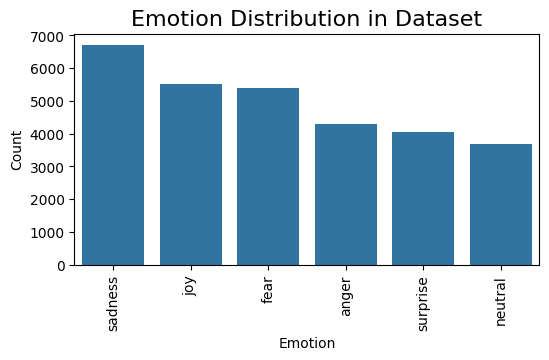

In [7]:
plt.figure(figsize=(6,3))
sns.barplot(x=df['Emotion'].value_counts().index,
            y=df['Emotion'].value_counts().values)
plt.title("Emotion Distribution in Dataset", fontsize=16)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

## Further Processing Context
We clean up the tweet content to be easily understandable for the model.

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(Text):
    Text = str(Text).lower()  # Convert to string and then to lowercase
    Text = re.sub(r'http\S+', '', Text)
    Text = re.sub(r'\d+', '', Text)
    Text = Text.translate(str.maketrans('', '', string.punctuation))
    Text = re.sub(r'\s+', ' ', Text).strip()
    return Text

df['clean_text'] = df['Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
df

,Emotion,Text,clean_text
0,joy,That's what I cal.. Happiness!! RT @Aalshibl: ...,thats what i cal happiness rt aalshibl playing...
1,joy,Bought my first xmas gifts today!! So full of ...,bought my first xmas gifts today so full of i ...
2,joy,"Now , the effort pays off . You have accompli...",now the effort pays off you have accomplished ...
3,joy,that proud moment when you can honestly day yo...,that proud moment when you can honestly day yo...
4,joy,"Nevertheless , no writer , however self-suffic...",nevertheless no writer however selfsufficient ...
...,...,...,...
29688,surprise,@_SophCo_ surprise me as in you got on the wro...,sophco surprise me as in you got on the wrong ...
29689,surprise,just found both of my white camis that have be...,just found both of my white camis that have be...
29690,fear,The average adult spends four years of their l...,the average adult spends four years of their l...
29691,fear,"â€œ@RevRunWisdom: not afraid of tomorrow, for ...",â€œrevrunwisdom not afraid of tomorrow for i h...


In [10]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Encode labels numerically
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Emotion"])

# Keep only necessary columns
dataset = Dataset.from_pandas(df[["clean_text", "label"]])

## Split Test and Train

In [11]:
dataset = dataset.train_test_split(test_size=0.3, seed=42)

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
def tokenize(batch):
    return tokenizer(
        batch["clean_text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/20785 [00:00<?, ? examples/s]

Map:   0%|          | 0/8908 [00:00<?, ? examples/s]

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(label_encoder.classes_)
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./roberta-emotion",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

In [17]:
!pip install evaluate -q
import numpy as np
from evaluate import load

metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-1550472232.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.062000,0.907560,0.680287
2,0.733900,0.898489,0.697575
3,0.523000,0.978831,0.707566


TrainOutput(global_step=7797, training_loss=0.7729662525450494, metrics={'train_runtime': 1804.3395, 'train_samples_per_second': 34.558, 'train_steps_per_second': 4.321, 'total_flos': 4101719769699840.0, 'train_loss': 0.7729662525450494, 'epoch': 3.0})

## Checking Performance

In [19]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.9788309335708618, 'eval_accuracy': 0.7075662325999101, 'eval_runtime': 63.6032, 'eval_samples_per_second': 140.056, 'eval_steps_per_second': 17.515, 'epoch': 3.0}


In [20]:
trainer.save_model("roberta-emotion-model")
tokenizer.save_pretrained("roberta-emotion-model")

('roberta-emotion-model/tokenizer_config.json',
 'roberta-emotion-model/special_tokens_map.json',
 'roberta-emotion-model/vocab.json',
 'roberta-emotion-model/merges.txt',
 'roberta-emotion-model/added_tokens.json',
 'roberta-emotion-model/tokenizer.json')

## Inference

In [33]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

labels = ["anger", "fear", "joy", "neutral", "sadness", "surprise"]

id2label = {i: label for i, label in enumerate(labels)}
label2id = {label: i for i, label in enumerate(labels)}

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-emotion-model",
    id2label=id2label,
    label2id=label2id
)

tokenizer = AutoTokenizer.from_pretrained("roberta-emotion-model")

pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None
)

print(pipe("I am so happy right now..."))

Device set to use cuda:0


[[{'label': 'joy', 'score': 0.9936257600784302}, {'label': 'surprise', 'score': 0.0024820987600833178}, {'label': 'sadness', 'score': 0.001508053275756538}, {'label': 'neutral', 'score': 0.0010732087539508939}, {'label': 'fear', 'score': 0.0006950596580281854}, {'label': 'anger', 'score': 0.0006157671450637281}]]
